<a href="https://colab.research.google.com/github/Deauth-Eater/Divination/blob/main/WoW-PvP-3v3-Leaderboards-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [28]:
CLIENT_ID = ""
CLIENT_SECRET = ""
REGION = "eu" #"us"
LOCALE = "en_GB" #"en_US"

## Part 1: Gather & Store Data

In [3]:
#!pip install python-blizzardapi

In [4]:
from blizzardapi import BlizzardApi
api_client = BlizzardApi(CLIENT_ID, CLIENT_SECRET)

In [5]:
def get_season_ids():
  season_ids=[]
  
  response = api_client.wow.game_data.get_pvp_seasons_index(region=REGION,
                                                            locale=LOCALE)
  for season in response['seasons']:
    season_ids.append(season['id'])

  return season_ids

season_ids = get_season_ids()

In [6]:
def get_leaderboard(season_id,bracket):
  name,realm,faction,rank,rating,played,won,lost,tier_id = ([] for i in range(9))

  response = api_client.wow.game_data.get_pvp_leaderboard(region=REGION,
                                                          locale=LOCALE,
                                                          pvp_season_id=season_id,
                                                          pvp_bracket=bracket)
  try:
    for entry in response['entries']:
      name.append(entry['character']['name'].lower())
      realm.append(entry['character']['realm']['slug'])
      faction.append(entry['faction']['type'].lower())
      rank.append(entry['rank'])
      rating.append(entry['rating'])
      played.append(entry['season_match_statistics']['played'])
      won.append(entry['season_match_statistics']['won'])
      lost.append(entry['season_match_statistics']['lost'])
      tier_id.append(entry['tier']['id'])
  except KeyError:
    pass
      
  leaderboard = pd.DataFrame(list(zip(name,realm,faction,rank,rating,
                                      played,won,lost,tier_id)),
                            columns=['name','realm','faction','rank','rating',
                                     'played','won','lost','tier_id'])
  
  leaderboard['season_id'] = season_id
  
  return leaderboard

In [7]:
leaderboards = pd.DataFrame(columns=['name','realm','faction','rank','rating',
                                     'played','won','lost','tier_id','season_id'])

In [8]:
for season_id in season_ids:
  leaderboards = pd.concat([get_leaderboard(season_id,"3v3"),
                            leaderboards], axis=0)

In [9]:
tiers_index = api_client.wow.game_data.get_pvp_tiers_index(region=REGION,
                                                           locale=LOCALE)['tiers']
def get_tier(tier_id):
  for tier in tiers_index:
    if tier['id'] == tier_id:
      return tier['name']

leaderboards['tier'] = np.vectorize(get_tier)(leaderboards['tier_id'])

In [10]:
def get_class(realm,name):
  response = api_client.wow.profile.get_character_profile_summary(region=REGION,
                                                                  locale=LOCALE,
                                                                  realm_slug=realm,
                                                                  character_name=name)
  try:
    return response['character_class']['name'].lower()
  except KeyError:
    return pd.NA

#leaderboards['class'] = np.vectorize(get_class)(leaderboards['realm'],leaderboards['name'])

In [11]:
leaderboards.to_csv('leaderboards.csv',index=False)

## Part 2: Clean & Organize Data

In [12]:
leaderboards = pd.read_csv('leaderboards.csv')

In [13]:
leaderboards = leaderboards.drop('tier_id',axis=1)

In [14]:
leaderboards['win_rate'] = round(leaderboards['won']/leaderboards['played']*100,1)

## Part 3: EDA

### What does the dataset look like?

In [15]:
leaderboards

,name,realm,faction,rank,rating,played,won,lost,season_id,tier,win_rate
0,sadhole,kazzak,horde,1,2606,173,124,49,32,Elite,71.7
1,raíku,ravencrest,alliance,2,2605,84,78,6,32,Elite,92.9
2,iniquitatem,ravencrest,alliance,2,2605,84,78,6,32,Elite,92.9
3,whaazz,ravencrest,alliance,2,2605,84,78,6,32,Elite,92.9
4,fnoberz,ravencrest,horde,5,2596,120,81,39,32,Elite,67.5
...,...,...,...,...,...,...,...,...,...,...,...
30052,ktdos,ravencrest,alliance,4995,2159,186,100,86,27,Duelist,53.8
30053,dotpixel,stormscale,horde,4995,2159,366,196,170,27,Duelist,53.6
30054,tokyø,outland,alliance,4995,2159,599,313,286,27,Duelist,52.3
30055,enô,blackrock,horde,4995,2159,393,201,192,27,Duelist,51.1


### Which *seasons* are included in this dataset?

In [16]:
leaderboards['season_id'].unique()

array([32, 31, 30, 29, 28, 27])

### What's the current *season*?

In [17]:
leaderboards['season_id'].unique()[0]

32

### How many top rated players per *season* are provided within this dataset?

In [18]:
leaderboards['season_id'].value_counts().sort_index(ascending=False)

32    5009
31    5008
30    5013
29    5009
28    5002
27    5016
Name: season_id, dtype: int64

### *Who* holds the highest *rating*?

In [19]:
leaderboards.nlargest(1,'rating')

,name,realm,faction,rank,rating,played,won,lost,season_id,tier,win_rate
5009,âzx,kazzak,horde,1,3815,4204,2478,1726,31,Elite,58.9


### *Who* holds the highest *win rate*?

In [20]:
leaderboards.nlargest(1,'win_rate')

,name,realm,faction,rank,rating,played,won,lost,season_id,tier,win_rate
16236,mitsutsuki,ravencrest,alliance,1207,2705,99,97,2,29,Elite,98.0


### Is the matchmaking algorithm well developed?
The correlation coefficient, *r*, for the relationship between matches *won* and 
<br>
matches *lost* would be a very good error metric for the
<br>
matchmaking algorithm if all ranked 3v3 players were included in the dataset.
<br><br>
Doesn't really work here though, as only the top 5k players are included for each season,
<br>
thereby excluding the players that lose a lot.

In [21]:
r = leaderboards['won'].corr(leaderboards['lost'])
if r > 0.95:
  print('yes:',r)
else:
  print('no:',r)

yes: 0.983837418329473


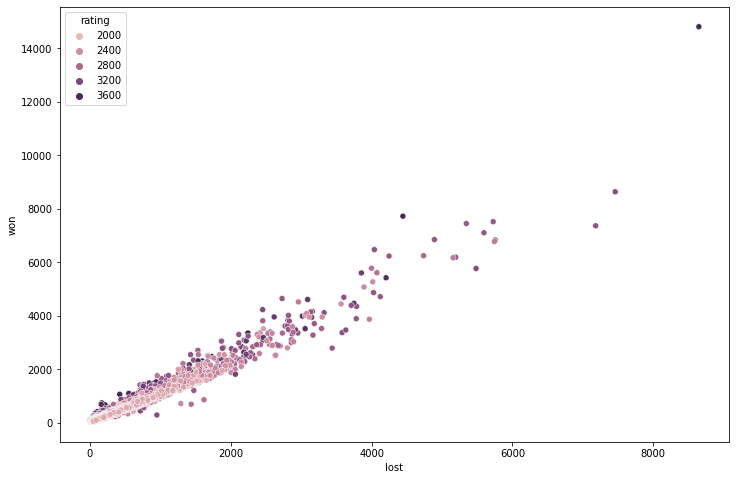

In [22]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=leaderboards,x='lost',y='won',hue='rating');

### *Who's* the outlier?

In [23]:
leaderboards[leaderboards['lost'] > 8000]

,name,realm,faction,rank,rating,played,won,lost,season_id,tier,win_rate
5081,дракомелфой,howling-fjord,horde,71,3608,23456,14807,8649,31,Elite,63.1


### What does relationship between *rating* and matches *played* look like?
The following scatterplot portrays:
* matches *played* on the x-axis
* the *rating* on the y-axis
* the *tiers* on the "z-axis"
* how the *ratings* are distributed amongst the *tiers* on the yz-plane

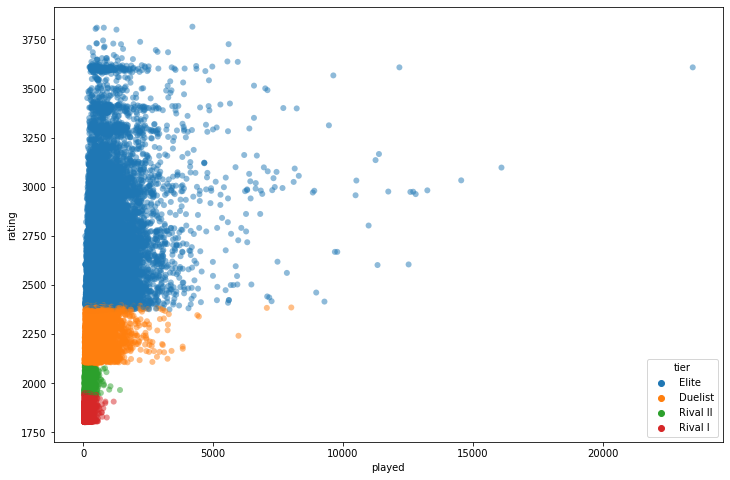

In [24]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=leaderboards,x='played',y='rating',
                hue='tier',linewidth=0,alpha=0.5);

### Which *faction* has the highest mean *rating*?

In [25]:
leaderboards.groupby('faction')['rating'].mean().nlargest(1)

faction
alliance    2468.434138
Name: rating, dtype: float64

### Which *realm* has the highest *rating* on average?

In [26]:
top_realm = leaderboards.groupby('realm')['rating'].mean().nlargest(1)
top_realm

realm
suramar    2742.552632
Name: rating, dtype: float64

### Which *faction* dominates this *realm*?

In [27]:
leaderboards[leaderboards['realm'] == top_realm.index[0]]['faction'].value_counts(normalize=True).nlargest(1)

alliance    0.710526
Name: faction, dtype: float64